# Lab 3 - Principal Component Analysis

This notebook introduces the Principal Component Analysis, its visualization and spatial analysis.

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
We will begin this exercise reviewing Principal Component Analysis (PCA), a core method of both multivariate statistics and machine learning used for dimension reduction. Dimension reduction is particularly relevant in situations where many variables are available that are highly intercorrelated. In essence, the original variables are replaced by a smaller number of proxies that represent them well in terms of their statistical properties.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to these packages, in order to achieve our goal of spatializing the Principal Component Analysis, we will also need **pygeoda**, a python library for spatial data analysis developed by Xun Li and Luc Anselin. For more information on the library, please check https://geodacenter.github.io/pygeoda/index.html . As in the previous notebook, if not already installed, the library can be installed running `pip install pygeoda` from your terminal or notebook. Make sure you have the latest version with `pip install -U pygeoda`.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pygeoda

### Load data

For this exercise, we will use a data set on Italy Community Banks from Algeri et al (2022). This is also a GeoDa sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Italy-Community-Banks/

The following files will be used:
- **italy_banks.shp,shx,dbf,prj**: shape file (four files) for 261 points in UTM zone 32, no Sardinia or Elba 

We follow the usual practice of setting a path (if needed), reading the data from the Italian banks shape file and a quick check of its contents (`head`).

In [2]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Guerry Moral Statistics data:
dfs = gpd.read_file(path+"italy_banks/italy_banks.shp")
print(dfs.shape)
dfs.head(3)

(261, 102)


,idd,BankName,City,latitud,longitud,COORD_X,XKM,COORD_Y,YKM,ID,...,EXPE_16,EXPE_17,SERV_11,SERV_12,SERV_13,SERV_14,SERV_15,SERV_16,SERV_17,geometry
0,1.0,Banca di Andria di Credito Cooperativo SocietÃ...,ANDRIA,41.226694,16.302685,1.112303e+06,1112.303366,4.589794e+06,4589.793823,1.0,...,0.027966,0.025114,0.793877,0.775691,0.745046,0.630469,0.611941,0.640208,0.666425,POINT (1112303.366 4589793.823)
1,8.0,Banca di Credito Cooperativo di Napoli-BCC di ...,NAPLES,40.841020,14.250822,9.427720e+05,942.771983,4.534476e+06,4534.475758,8.0,...,0.023624,0.018840,0.770019,0.562623,0.540712,0.522125,0.601549,0.502599,0.625220,POINT (942771.983 4534475.758)
2,9.0,Banca Adria Credito Cooperativo del Delta s.c....,ADRIA,45.052882,12.056720,7.407057e+05,740.705695,4.993464e+06,4993.464408,9.0,...,0.013770,0.012745,0.790542,0.626628,0.515733,0.358735,0.483700,0.567946,0.608880,POINT (740705.695 4993464.408)


#### Selecting variables and checking their correlation

We start with a computation of the pairwise correlations. Assessing the correlation is useful as the greater the correlation between the original variables, the more efficient will be the dimension reduction. Following Chapter 11 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/CHPCA.html), we select the following variables for 2013 from the Italian banks sample data set.

List of variables:
| Column Name  | Description                                                                             |
|--------------|-----------------------------------------------------------------------------------------|
| CAPRAT13     | Ratio of capital over risk-weighted assets                                              |
| Z_13         | Z-score of return on assets (ROA) + leverage over the standard deviation of ROA         |
| LIQASS_13    | Ratio of liquid assets over total assets                                                |
| NPL_13       | Ratio of non-performing loans over total loans                                          |
| LLP_13       | Ratio of loan loss provision over customer loans                                        |
| INTR_13      | Ratio of interest expense over total funds                                              |
| DEPO_13      | Ratio of total deposits over total assets                                               |
| EQLN_13      | Ratio of total equity over customer loans                                               |
| SERV_13      | Ratio of net interest income over total operating revenues                              |
| EXPE_13      | Ratio of operating expenses over total assets                                           |

The correlations are computed by applying the `corr` method to the subset of the data frame that contains the selected variables. The results are rounded to two decimals.

In [3]:
varlist = ['CAPRAT13', 'Z_13', 'LIQASS_13', 'NPL_13', 'LLP_13', 
                'INTR_13', 'DEPO_13', 'EQLN_13', 'EXPE_13', 'SERV_13']

In [4]:
data_pca = dfs[varlist]

round(data_pca.corr(), 2)

,CAPRAT13,Z_13,LIQASS_13,NPL_13,LLP_13,INTR_13,DEPO_13,EQLN_13,EXPE_13,SERV_13
CAPRAT13,1.00,-0.03,0.21,-0.08,-0.10,-0.39,0.18,0.87,0.14,0.32
Z_13,-0.03,1.00,-0.08,-0.28,-0.16,-0.02,-0.15,-0.02,-0.14,-0.04
LIQASS_13,0.21,-0.08,1.00,-0.00,-0.05,-0.14,0.23,0.09,0.18,0.01
NPL_13,-0.08,-0.28,-0.00,1.00,0.64,0.33,-0.09,-0.10,0.15,-0.20
LLP_13,-0.10,-0.16,-0.05,0.64,1.00,0.41,-0.19,-0.14,-0.04,-0.39
INTR_13,-0.39,-0.02,-0.14,0.33,0.41,1.00,-0.43,-0.48,-0.18,-0.40
DEPO_13,0.18,-0.15,0.23,-0.09,-0.19,-0.43,1.00,0.18,0.16,0.17
EQLN_13,0.87,-0.02,0.09,-0.10,-0.14,-0.48,0.18,1.00,0.12,0.39
EXPE_13,0.14,-0.14,0.18,0.15,-0.04,-0.18,0.16,0.12,1.00,0.07
SERV_13,0.32,-0.04,0.01,-0.20,-0.39,-0.40,0.17,0.39,0.07,1.00


Note that the correlations are all rather low, which will constitute a challenge for dimension reduction.

## Principal Components Analysis by hand

This section computes the PCA step-by-step, as if by hand, without using the already existing `PCA` function from `scikit-learn`. The objective is to understand what happens under the hood when computing PCA so the intuition behind its interpretation is clear. Later in this notebook, we will see the simplified version using the existing `PCA` function from `sklearn.decomposition`.

The first step is to standardize the data, which is accomplished using the `StandardScaler` class in `sklearn.preprocessing`. Recall how everything in scikit-learn is a class to which specific methods are applied or from which specific attributes are extracted. The method used for standardization to a mean of zero and variance of one is `fit_transform` applied to a `StandardScaler` object.

Descriptive statistics of the resulting data frame (`describe`) reveal that indeed the mean is zero and the standard deviation is one.

In [10]:
# Standardize the data
X = StandardScaler().fit_transform(data_pca)
pd.DataFrame(X).describe().round(2)

,0,1,2,3,4,5,6,7,8,9
count,261.00,261.00,261.00,261.00,261.00,261.00,261.00,261.00,261.00,261.00
mean,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.42,-0.76,-1.27,-1.94,-1.68,-2.28,-2.34,-1.33,-3.07,-2.34
25%,-0.64,-0.54,-0.75,-0.76,-0.69,-0.70,-0.74,-0.67,-0.66,-0.73
50%,-0.29,-0.29,-0.24,-0.11,-0.16,-0.04,-0.06,-0.28,-0.01,-0.10
75%,0.48,0.08,0.41,0.64,0.45,0.68,0.80,0.44,0.68,0.55
max,5.49,5.97,3.66,2.76,3.90,2.07,2.40,4.92,2.51,3.41


To illustrate the PCA calculation, we will use the eigenvalue decomposition method, applied to the $p \times p$ correlation matrix $X'X$. Note that this is the same correlation matrix as computed above using `data_pca.corr( )`.

In [11]:
# Calculate the correlation matrix:
# Here we are using X'X / p. Another way to do it would be simply: data_pca.corr()
p = X.shape[0]
C = np.dot(X.T, X) / p
C.round(2)

array([[ 1.  , -0.03,  0.21, -0.08, -0.1 , -0.39,  0.18,  0.87,  0.32,
         0.14],
       [-0.03,  1.  , -0.08, -0.28, -0.16, -0.02, -0.15, -0.02, -0.04,
        -0.14],
       [ 0.21, -0.08,  1.  , -0.  , -0.05, -0.14,  0.23,  0.09,  0.01,
         0.18],
       [-0.08, -0.28, -0.  ,  1.  ,  0.64,  0.33, -0.09, -0.1 , -0.2 ,
         0.15],
       [-0.1 , -0.16, -0.05,  0.64,  1.  ,  0.41, -0.19, -0.14, -0.39,
        -0.04],
       [-0.39, -0.02, -0.14,  0.33,  0.41,  1.  , -0.43, -0.48, -0.4 ,
        -0.18],
       [ 0.18, -0.15,  0.23, -0.09, -0.19, -0.43,  1.  ,  0.18,  0.17,
         0.16],
       [ 0.87, -0.02,  0.09, -0.1 , -0.14, -0.48,  0.18,  1.  ,  0.39,
         0.12],
       [ 0.32, -0.04,  0.01, -0.2 , -0.39, -0.4 ,  0.17,  0.39,  1.  ,
         0.07],
       [ 0.14, -0.14,  0.18,  0.15, -0.04, -0.18,  0.16,  0.12,  0.07,
         1.  ]])

With the correlation matrix in hand, we can compute the eigenvalues and eigenvectors. The elements of the eigenvectors will be used as loadings to combine the original variables into new variables that will be our Principal Components.

Note how the `linalg.eig` function returns a tuple, with two arrays. The first is a vector with the eigenvalues, the second is a $p \times p$ matrix with the eigenvectors are columns, i.e., the first column is the eigenvector for the first eigenvalue, etc.

Keep in mind that the eigenvalues will not necessarily be sorted. So we need to sort them from the greatest value to the smallest.

In [12]:
# Compute the eigenvalues and eigenvectors to use as loadings
E_values, E_vectors = np.linalg.eig(C)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(E_values)[::-1]
E_values = E_values[sorted_indices]
E_vectors = E_vectors[:, sorted_indices]

print('Eigenvalues',E_values.round(3))
print('Eigenvectors',E_vectors.round(3))

print('First PC factor loadings',E_vectors[:,0].round(3))

# Combine eigenvectors into a data frame
L = E_vectors
print('\nComponent Loadings:')
pd.DataFrame(L, index=data_pca.columns)

Eigenvalues [2.987 1.763 1.263 0.961 0.843 0.738 0.607 0.424 0.304 0.11 ]
Eigenvectors [[ 0.417 -0.289  0.4    0.201  0.054  0.035  0.178 -0.218  0.021  0.677]
 [ 0.014  0.42   0.236  0.565 -0.292 -0.392 -0.452 -0.068  0.04   0.003]
 [ 0.148 -0.229 -0.39   0.639  0.203  0.507 -0.205  0.129 -0.    -0.094]
 [-0.264 -0.546  0.081 -0.106 -0.07  -0.121 -0.409  0.063  0.65   0.032]
 [-0.333 -0.453  0.222  0.094  0.124 -0.234 -0.17   0.234 -0.687 -0.004]
 [-0.454 -0.03   0.14   0.082 -0.015  0.31  -0.013 -0.807 -0.083 -0.109]
 [ 0.277 -0.133 -0.483 -0.064  0.382 -0.542 -0.164 -0.443 -0.068 -0.024]
 [ 0.438 -0.241  0.44   0.068  0.027 -0.049  0.144 -0.085  0.06  -0.719]
 [ 0.363  0.066  0.091 -0.443 -0.114  0.35  -0.676 -0.068 -0.247  0.037]
 [ 0.131 -0.321 -0.348  0.026 -0.831 -0.065  0.151 -0.112 -0.164 -0.02 ]]
First PC factor loadings [ 0.417  0.014  0.148 -0.264 -0.333 -0.454  0.277  0.438  0.363  0.131]

Component Loadings:


,0,1,2,3,4,5,6,7,8,9
CAPRAT13,0.416651,-0.289011,0.400281,0.200754,0.054467,0.034624,0.177808,-0.218361,0.020765,0.677092
Z_13,0.013973,0.420044,0.235984,0.564699,-0.291502,-0.392045,-0.451626,-0.067665,0.039630,0.002815
LIQASS_13,0.147681,-0.229038,-0.390257,0.638757,0.202743,0.506880,-0.204524,0.129197,-0.000251,-0.094164
NPL_13,-0.264109,-0.546288,0.081384,-0.105872,-0.069770,-0.120596,-0.408614,0.063170,0.650065,0.032139
LLP_13,-0.332622,-0.452568,0.221917,0.094127,0.124286,-0.234403,-0.169731,0.234213,-0.687286,-0.004423
INTR_13,-0.454442,-0.030416,0.139912,0.081664,-0.015137,0.309591,-0.013168,-0.807004,-0.083059,-0.109131
DEPO_13,0.277034,-0.133345,-0.483049,-0.064276,0.381635,-0.541985,-0.163713,-0.443464,-0.067723,-0.023698
EQLN_13,0.438027,-0.240695,0.440113,0.068469,0.026698,-0.048546,0.143620,-0.084699,0.059671,-0.719291
SERV_13,0.362998,0.066494,0.090886,-0.443382,-0.113546,0.349947,-0.675579,-0.068169,-0.247354,0.036992
EXPE_13,0.130787,-0.321352,-0.347914,0.025643,-0.831361,-0.065367,0.151014,-0.111648,-0.163775,-0.019992


An important property of the principal components is how much of the original variance each explains. Since the ten variables are standardized the total variance equals 10. We verify that this is also the sum of the eigenvalues of $X'X$. Then we compute the share of each principal component.

In [13]:
# Variance decomposition
totvar = np.sum(E_values)
print('Total variance',totvar)

# Variance share
varshare = E_values / totvar
print('Share of total variance in each component:\n', varshare)

Total variance 10.000000000000004
Share of total variance in each component:
 [0.2986745  0.17631768 0.12628661 0.09612748 0.08433105 0.07383474
 0.06074807 0.04237308 0.03035229 0.01095451]


The loadings show us the weight of each original variable in the newly created components. They allow us to interpret and, potentially, label these new components so we can use fewer of them as replacements to our original variables, minimizing the overall variance loss. 

Note that all components are centered with a mean of 0. Their variances are equal to the eigenvalue that corresponds to the eigenvector that gave them origin. It is easy to show how the total original variance was just redistributed across the newly created components. No variance is lost but reorganized so that it is concentrated in the first components. This way, discarding the last components may have a negligible effect on overall variance whilst reducing the number of dimensions of the analysis.

## Principal Components Analysis - scikit-learn

In this section, we show the direct way to compute PCA using the existing `PCA` function from `sklearn.decomposition`. Instead of computing the spectral decomposition of the correlation matrix to return the eigenvalues and eigenvectors, `scikit-learn` uses a Singular Value Decomposition (SVD) of the original matrix of variables, in our case X. This is the same as the default method in `GeoDa`.

The method yields the same results as above when the data is standardized. However, the PCA computation returns a transposed matrix of eigenvectors ($V'$), i.e., each eigenvector is a row. 

For more on how Spectral Decomposition and SVD can be applied to Principal Components Analysis, see Anselin (2023) - https://lanselin.github.io/introbook_vol2/matrix-algebra-review.html#matrix-decompositions

In [14]:
# Repeating previous steps to ensure all required steps are shown in this section.
dfs = gpd.read_file(path+"italy_banks/italy_banks.shp")
data_pca = dfs[['CAPRAT13', 'Z_13', 'LIQASS_13', 'NPL_13', 'LLP_13', 'INTR_13', 'DEPO_13', 'EQLN_13', 'SERV_13', 'EXPE_13']]
X = StandardScaler().fit_transform(data_pca)

# Perform PCA 
pca_res = PCA().fit(X)

In the usual scikit-learn terminology, `pca_res` is now an object of the class `PCA` (once we initialized using `PCA()` and applied the `fit` method), which has several important attributes:
- `components_`: the factor loadings as an array of rows (not columns as in the example above), one for each component. So, the first row contains the loadings for the first PC, etc.
- `explained_variance_`: the explained variance by each component. As shown above, this corresponds to the matching eigenvalue of $X'X$.
- `explained_variance_ratio_`: the share of the total variance explained by each component
as well as several other, more technical attributes.

The actual components are found by applying `transform(X)` to the PCA result object. This yields a n by k numpy array with the observations as rows and the component scores as columns.

We now list each in turn.

In [15]:
# Component loadings, row by row
pd.DataFrame(pca_res.components_, index=range(1,pca_res.components_.shape[0]+1), 
             columns=data_pca.columns)


,CAPRAT13,Z_13,LIQASS_13,NPL_13,LLP_13,INTR_13,DEPO_13,EQLN_13,SERV_13,EXPE_13
1,-0.416651,-0.013973,-0.147681,0.264109,0.332622,0.454442,-0.277034,-0.438027,-0.362998,-0.130787
2,0.289011,-0.420044,0.229038,0.546288,0.452568,0.030416,0.133345,0.240695,-0.066494,0.321352
3,-0.400281,-0.235984,0.390257,-0.081384,-0.221917,-0.139912,0.483049,-0.440113,-0.090886,0.347914
4,0.200754,0.564699,0.638757,-0.105872,0.094127,0.081664,-0.064276,0.068469,-0.443382,0.025643
5,-0.054467,0.291502,-0.202743,0.069770,-0.124286,0.015137,-0.381635,-0.026698,0.113546,0.831361
6,-0.034624,0.392045,-0.506880,0.120596,0.234403,-0.309591,0.541985,0.048546,-0.349947,0.065367
7,-0.177808,0.451626,0.204524,0.408614,0.169731,0.013168,0.163713,-0.143620,0.675579,-0.151014
8,0.218361,0.067665,-0.129197,-0.063170,-0.234213,0.807004,0.443464,0.084699,0.068169,0.111648
9,-0.020765,-0.039630,0.000251,-0.650065,0.687286,0.083059,0.067723,-0.059671,0.247354,0.163775
10,-0.677092,-0.002815,0.094164,-0.032139,0.004423,0.109131,0.023698,0.719291,-0.036992,0.019992


In [17]:
# Explained variance of each component
pca_res.explained_variance_

array([2.99823249, 1.76995822, 1.26772324, 0.96497201, 0.84655397,
       0.74118715, 0.60981717, 0.42536058, 0.30469032, 0.10996639])

In [18]:
# Explained variance share
print("Explained variance share:",pca_res.explained_variance_ratio_)
print("\nCumulative variance share:",np.cumsum(pca_res.explained_variance_ratio_))

Explained variance share: [0.2986745  0.17631768 0.12628661 0.09612748 0.08433105 0.07383474
 0.06074807 0.04237308 0.03035229 0.01095451]

Cumulative variance share: [0.2986745  0.47499218 0.60127878 0.69740626 0.78173731 0.85557205
 0.91632012 0.9586932  0.98904549 1.        ]


In [19]:
# The actual principal components
pcomps = pca_res.transform(X) 
pcomps[0:5,0]

array([-2.26679046, -1.17912038,  1.51954157,  2.31900576,  2.36956218])

### How many components?

The choice of how many components to keep is not an easy one. There are several shortcut criteria, but they often yield different recommendations.
For example, one would suggest to keep all the components until the explained variance is 95% of the original. In our example, that would mean keeping eight components (out of ten), which is not exactly dimension reduction.

The Kaiser criterion suggests keeping the principal components with eigenvalues larger than one. This would yield three components, a more reasonable reduction.

A graphical method to assess the number of components is the so-called *scree plot*, a plot of explained variance against the number of components. The goal is to identify a *kink* in this plot, which then suggests the proper number of components. In practice, this is not as easy as it sounds, as the example below illustrates.

We implement a scree plot by means of a simple matplotlib line plot with the explained variance ratio (`explained_variance_ratio_`) on the vertical axis and a simple counter on the horizontal axis. As the graph shows, it is not easy at all to identify the *kink*.

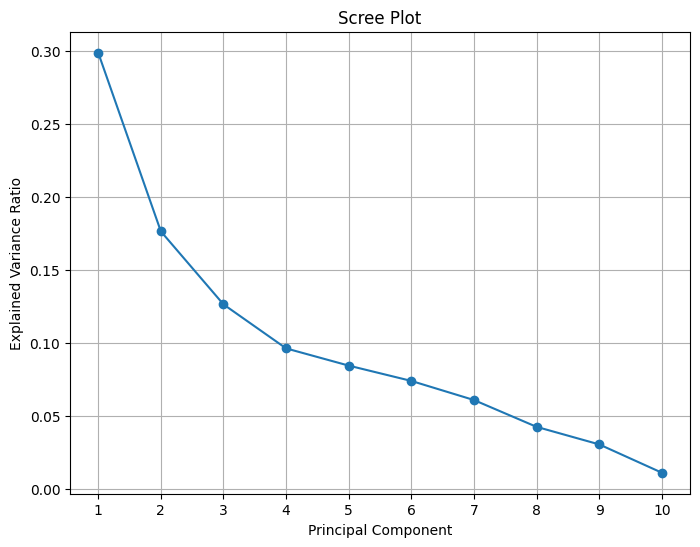

In [20]:
#Screeplot of variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_res.explained_variance_ratio_) + 1), pca_res.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(pca_res.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

### Visualizing principal components

A classic visualization of the relative contribution of the original variables to the principal components is a so-called *biplot*. For any pair of components, it consists of a scatter plot of the component values, with superimposed line plots that show the relative contribution of each variable to each of the components.

For example, a line plot that points to the upper-right quadrant in the scatter plot (e.g., `LLP_13`) would indicate that the variable in question contributes positively to both components (note that the results may yield different signs for the loadings, depending on the method used). On the other hand, a line plot that points to the upper-left quadrant (e.g., `CAPRAT13`) would suggest a negative contribution to the first component, but a positive contribution to the second (on the y-axis).

Below, we illustrate the biplot by means of a simple function using a number of basic matplotlib plotting functions.

In the biplot below, we have re-scaled the loadings by multiplying them by 4 just so they get more visible in the graph.

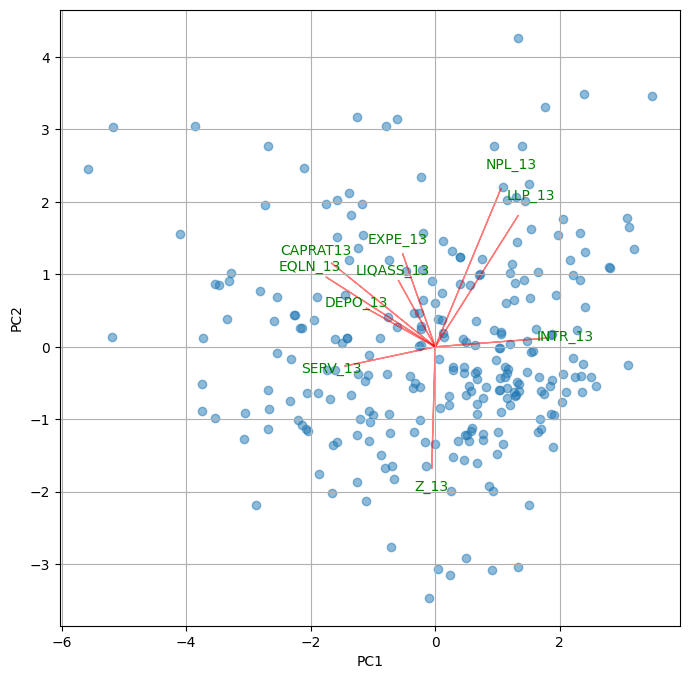

In [21]:
# Biplot
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(score[:, 0], score[:, 1], alpha=0.5)
    for i in range(len(coeff)):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, "Var" + str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, labels[i], color='g', ha='center', va='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.show()

biplot(pca_res.transform(X)[:, :2], pca_res.components_.T*4, labels=data_pca.columns)

Other visualizations, such as the ones illustrated in the Spatial Clustering book can be pursued as well, including a parallel coordinate plot showing the contributions of different variables to a component. This is not further pursued here.

### Spatializing the PCA

As described in the Spatial Clustering book, there are several ways in which the results of a principal components calculation can be visualized. The basic idea is that a component (typically the first principal component) summarizes several underlying variables and therefore can be used as a proxy for multivariate relationships. In essence then, a univariate spatial visualization of a principal component provides insight into multivariate spatial patterns.

All the usual visualizations can be applied, such as various thematic maps and cluster maps from indicators of local spatial autocorrelation. Care must be taken in interpreting these results, since the sign of the loadings is indeterminate (so high can become low and vice versa). In addition, one can assess the similarity in results of a full multivariate approach, such as a multivariate local Geary or a neighbor match map and the univariate results for the principal component. This is not further pursued here.

We close the notebook with an illustration of a box map and a local moran cluster map for the first principal component.

The strongest loadings (absolute values > 0.3) in PC1 are:

    Negative:
        CAPRAT13 (-0.42) → Capital adequacy
        EQLN_13 (-0.44) → Equity over loans
        SERV_13 (-0.36) → Net interest income over revenues
    Positive:
        LLP_13 (0.33) → Loan loss provisions
        INTR_13 (0.45) → Interest expenses

Therefore, PC1 contrasts capital adequacy and profitability (negative loadings on CAPRAT13, EQLN_13, and SERV_13) with credit risk and funding costs (positive loadings on LLP_13 and INTR_13). Low PC1 values represent banks with higher capital adequacy, more equity, and stronger deposit bases. High PC1 values represent banks with higher credit risk, loan loss provisions, and funding costs, indicating capital inadequacy and financial strain. An appropriate label for PC1 could be "Credit Risk & Funding Costs vs. Capital Adequacy".

#### Box map

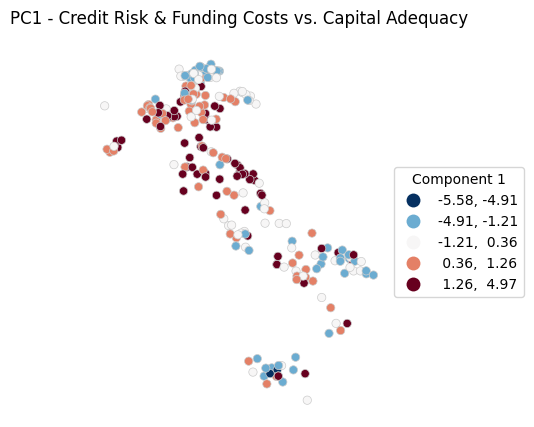

In [22]:
# Box map of Component 1:
dfs['Comp.1'] = pca_res.transform(X)[:, 0] 

ax = dfs.plot(
column = 'Comp.1',
scheme = "BoxPlot",
k = 6,
cmap='RdBu_r', 
linewidth=0.5, 
edgecolor='0.8',
legend = True,
legend_kwds={"loc":"center left","bbox_to_anchor":(1,0.5), "title": "Component 1"}
)
ax.set_title("PC1 - Credit Risk & Funding Costs vs. Capital Adequacy")
ax.set_axis_off()

#### Local Moran cluster map

We use `pygeoda` to compute the Local Moran statistic. This requires three steps:
- `open` the geodataframe
- create `queen_weights` from the geodataframe
- compute a `local_moran` object passing the weights and the variable
  - optional arguments are `permutations` for the number of permuations (default is 999), `seed` for the random seed (default is 1234567), and `significance_cutoff` for the p-value that determines significance (default is 0.05)

In our illustration, we use the first principal component with 9999 permutations and a p-value cut-off of 0.01.

The resulting `lisa object` contains the statistics, `lisa_values`, associated p-values, `lisa_pvalues`, the neighbor cardinality, `lisa_num_nbrs`, the cluster classification, based on the specified p-value, `lisa_clusters`, labels, `lisa_labels`, and associated colors, `lisa_colors`.

In [23]:
dfs_g = pygeoda.open(dfs)
queen_w = pygeoda.queen_weights(dfs_g)
lm = pygeoda.local_moran(queen_w, dfs_g['Comp.1'], permutations = 9999, seed = 1234567,
                         significance_cutoff = 0.01)
lm

lisa object:

	lisa_values(): [0.005296951235279858, -0.3184600483378756, 0.36298009350110205, 1.1090439865293087, 1.17108997595931, 1.0569249841311064, -1.3445446406378438, 0.055015911773549885, -0.14889762111052543, 0.29161152061474355, ...]
	lisa_pvalues(): [0.4801, 0.1814, 0.0859, 0.019, 0.0077, 0.0422, 0.0716, 0.0966, 0.021, 0.2121, ...]
	lisa_num_nbrs(): [6, 4, 10, 5, 6, 6, 5, 8, 5, 5, ...]
	lisa_clusters(): [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...]
	lisa_labels(): ('Not significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low', 'Undefined', 'Isolated')
	lisa_colors(): ('#eeeeee', '#FF0000', '#0000FF', '#a7adf9', '#f4ada8', '#464646', '#999999')

Note that this listing is actually a bit misleading, since all methods except `lisa_pvalues()` return *tuples*, not *lists*. In practice, this doesn't matter much, since they are typically converted to numpy arrays or pandas series anyway.

In addition, there are two functions to obtain the Bonferroni bound p cut-off and the False Discovery Rate (FDR) p-value, respectively as `lm.lisa_bo(pvalue)` and `lm.lisa_fdr(pvalue)`, where p-value is typically 0.05. Note that smaller values may not yield a feasible cut-off given the maximum number of permutations. However, in contrast to what is the case for desktop `GeoDa`, the `pygeoda` implementation allows any value for the number of permutations. 

We illustrate this for a target p-value of 0.05.

In [25]:
print("Bonferroni bound: ",np.round(lm.lisa_bo(0.05),6))
print("FDR: ",np.round(lm.lisa_fdr(0.05),6))

Bonferroni bound:  0.000192
FDR:  0.009962


With the usual commands, we create a custom local cluster map using the `lisa_colors` and `lisa_labels`.

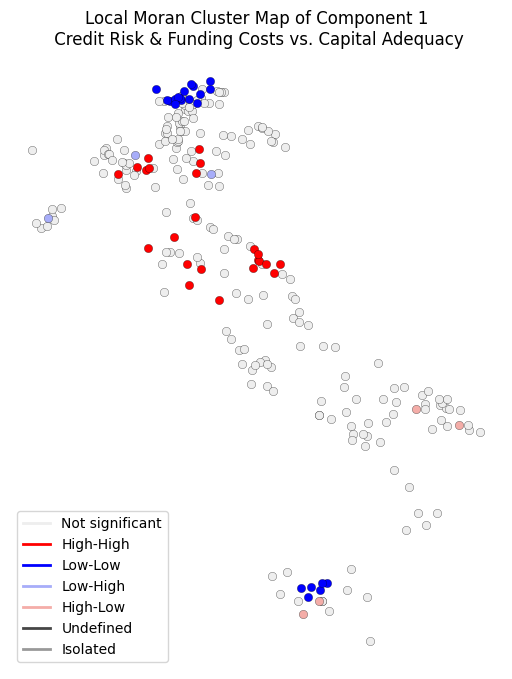

In [26]:
fig, ax = plt.subplots(figsize = (8,8))
lisa_colors = lm.lisa_colors()
lisa_labels = lm.lisa_labels()

dfs['LISA'] = lm.lisa_clusters()

for ctype, data in dfs.groupby('LISA'):
    color = lisa_colors[ctype]
    lbl = lisa_labels[ctype]
    data.plot(color = color,
        ax = ax,
        label = lbl,
        edgecolor = 'black',
        linewidth = 0.2)

# Place legend in the lower right hand corner of the plot
lisa_legend = [pltlines.Line2D([0], [0], color=color, lw=2) for color in lisa_colors]
ax.legend(lisa_legend, lisa_labels,loc='lower left', fontsize=10, frameon=True)
ax.set(title='Local Moran Cluster Map of Component 1\n Credit Risk & Funding Costs vs. Capital Adequacy')
ax.set_axis_off()
